# Import Libraries

- for homework dataset link : https://www.kaggle.com/datasets/vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images

In [ ]:
# To get multi output in jupyternotebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers ,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50  # ODEVVV Homework
from tensorflow.keras import Model

from pathlib import Path
import os.path

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


import warnings 
warnings.filterwarnings("ignore")


# Load Dataset 

In [ ]:
# You should download the data set as a zip file from the link and copy it to the path of the main.ipynb file after extracting
dataset="Data Combined"
image_dir=Path(dataset)

filepaths=list(image_dir.glob(r"**/*.JPG")) +list(image_dir.glob(r"**/*.PNG"))

labels=list(map(lambda x:os.path.split(os.path.split(x)[0])[1],filepaths))

filepaths=pd.Series(filepaths,name="filepath").astype(str)
labels=pd.Series(labels,name="label")

image_df=pd.concat([filepaths,labels],axis=1)


# Data visualization

Text(0.5, 1.0, 'Decolgen')

Text(0.5, 1.0, 'Biogesic')

Text(0.5, 1.0, 'Neozep')

Text(0.5, 1.0, 'Fish Oil')

Text(0.5, 1.0, 'Bioflu')

Text(0.5, 1.0, 'Biogesic')

Text(0.5, 1.0, 'Decolgen')

Text(0.5, 1.0, 'Decolgen')

Text(0.5, 1.0, 'Medicol')

Text(0.5, 1.0, 'Neozep')

Text(0.5, 1.0, 'Fish Oil')

Text(0.5, 1.0, 'DayZinc')

Text(0.5, 1.0, 'Decolgen')

Text(0.5, 1.0, 'Kremil S')

Text(0.5, 1.0, 'Kremil S')

Text(0.5, 1.0, 'Decolgen')

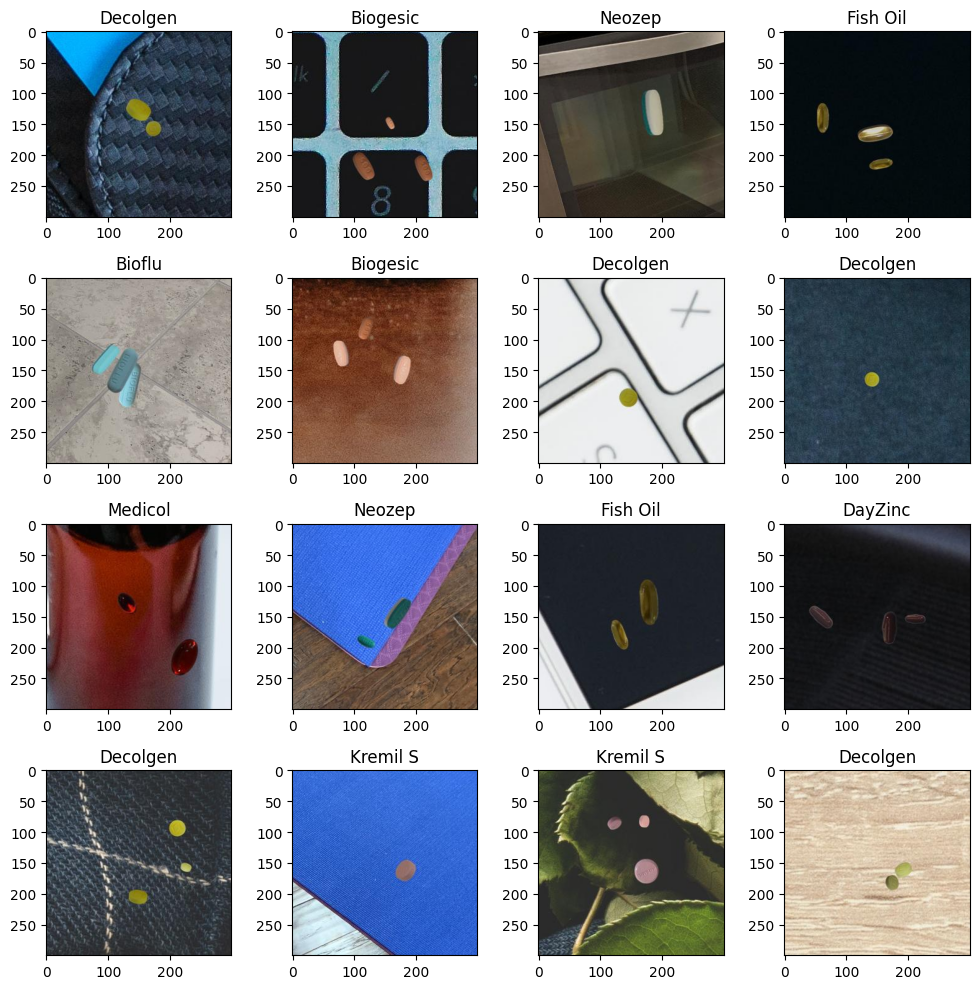

In [3]:
rand_index=np.random.randint(0,len(image_df),16)
fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(10,10))

for i ,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepath[rand_index[i]]))
    ax.set_title(image_df.label[rand_index[i]])
    
plt.tight_layout()

# Data Preprocessing : train-test-split , data augmentation , resize ,rescalling

In [4]:
#train-test-split
train_df,test_df=train_test_split(image_df,test_size=0.2,shuffle=True,random_state=42)

In [ ]:
# data augmentation: data augmentation

#ODEV
from tensorflow.keras.applications.resnet import preprocess_input  # Genel ResNet desteği - general resnet support


train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224), #goruntulerin boyutu
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
    subset="training"
    ) # 8000*0.8=6400 image secti



Found 6400 validated image filenames belonging to 10 classes.


In [6]:
val_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224), #goruntulerin boyutu
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64, 
    shuffle=True,
    seed=42,
    subset="validation"
    )   # 1600 val -> 0.2lik kısım

Found 1600 validated image filenames belonging to 10 classes.


In [7]:
test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224), #goruntulerin boyutu
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64, 
    shuffle=False
    )  # 0.2 lik 10000 ->2000 adet test

Found 2000 validated image filenames belonging to 10 classes.


In [8]:
# resize,rescale
resize_and_rescalling=tf.keras.Sequential(
    [
        layers.Resizing(224, 224),
        layers.Rescaling(1.0 / 255)
    ]
)

# Odev - ResNet Transfer Learning Model  , traning

In [10]:
pretrained_model = ResNet50(
    input_shape=(224,224,3),  # Görsellerin giriş boyutu
    include_top=False,  # Üstteki tam bağlı katmanları kaldır
    weights="imagenet",  # ImageNet ile önceden eğitilmiş ağırlıkları kullan
    pooling="avg"  # Global Average Pooling (GAP) katmanı ekle
)

pretrained_model.trainable = False  # Modeli dondur, sadece yeni eklediğimiz katmanlar eğitilecek


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


In [11]:
# Create checkpoint callback
checkpoint_path = "checkpoint.weights.h5"  # Corrected file extension

checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,  # Save only the model weights
    monitor="val_accuracy",  # Monitor validation accuracy
    save_best_only=True  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop training if validation loss doesn't improve
    patience=5,  # Number of epochs to wait before stopping
    restore_best_weights=True
)


In [12]:
#traing model -CLASSIFICATION BLOCK

inputs=pretrained_model.input
x=resize_and_rescalling(inputs)

x=Dense(256,activation="tanh")(pretrained_model.output)
x=Dropout(0.2)(x)
x=Dense(256,activation="relu")(x)
x=Dropout(0.2)(x)
x=Dense(128,activation="relu")(x)
x=Dropout(0.2)(x)


outputs=Dense(10,activation="softmax")(x)

model=Model(inputs,outputs)

In [13]:
model.compile(optimizer=Adam(0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

history=model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[early_stopping,checkpoint_callback]
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.2000 - loss: 2.2153 - val_accuracy: 0.6263 - val_loss: 1.4207
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 367s 4s/step - accuracy: 0.5441 - loss: 1.4040 - val_accuracy: 0.7744 - val_loss: 0.8443
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - accuracy: 0.6978 - loss: 0.9314 - val_accuracy: 0.8238 - val_loss: 0.6089
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.7782 - loss: 0.6842 - val_accuracy: 0.8581 - val_loss: 0.4903
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.8066 - loss: 0.5683 - val_accuracy: 0.8675 - val_loss: 0.4340
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - accuracy: 0.8488 - loss: 0.4428 - val_accuracy: 0.8737 - val_loss: 0.4001
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.8698 - loss: 0.3797 - val_accuracy: 0.8769 - val_loss: 0.3746
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.8974 - loss: 0.3094 - val_accu

# Model Evaluation

32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9041 - loss: 0.2786
test loss : 0.3191620707511902  ,  test accuracy : 0.8934999704360962


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

<Axes: >

Text(0.5, 1.0, 'Training and Validation Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

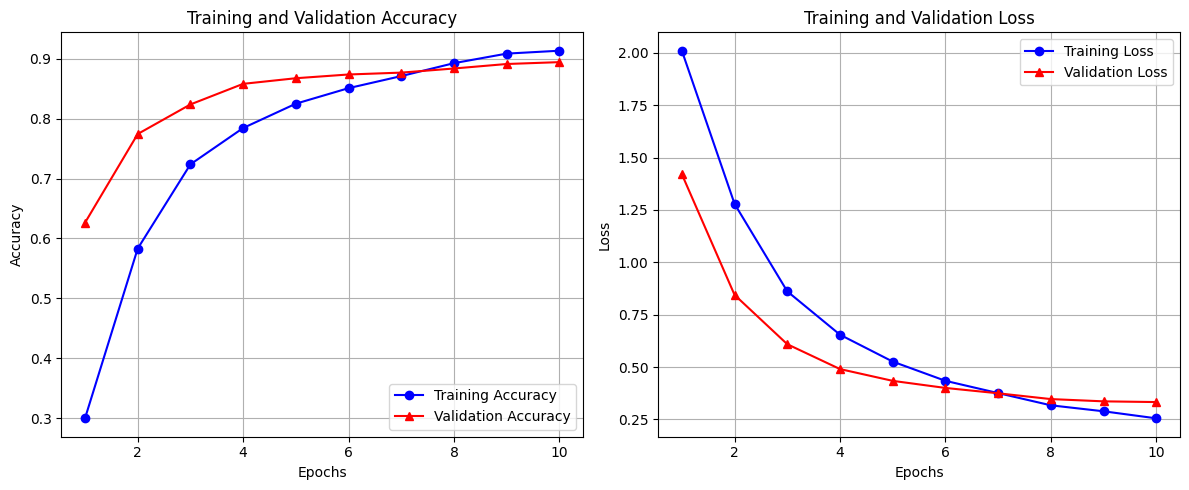

In [14]:
results=model.evaluate(test_images,verbose=1)
print(f"test loss : {results[0]}  ,  test accuracy : {results[1]}")


epochs=range(1,len(history.history["accuracy"])+1)
hist=history.history

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs,hist["accuracy"],"bo-",label="Training Accuracy")
plt.plot(epochs,hist["val_accuracy"],"r^-",label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs,hist["loss"],"bo-",label="Training Loss")
plt.plot(epochs,hist["val_loss"],"r^-",label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
pred=model.predict(test_images)
pred=np.argmax(pred,axis=1)

labels=(train_images.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred=[labels[k] for k in pred]


32/32 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step


Text(0.5, 1.0, 'True : Alaxan\n predicted: Biogesic')

Text(0.5, 1.0, 'True : Medicol\n predicted: Medicol')

Text(0.5, 1.0, 'True : DayZinc\n predicted: DayZinc')

Text(0.5, 1.0, 'True : Decolgen\n predicted: Decolgen')

Text(0.5, 1.0, 'True : Biogesic\n predicted: Biogesic')

Text(0.5, 1.0, 'True : Kremil S\n predicted: Decolgen')

Text(0.5, 1.0, 'True : Decolgen\n predicted: Decolgen')

Text(0.5, 1.0, 'True : Medicol\n predicted: Medicol')

Text(0.5, 1.0, 'True : DayZinc\n predicted: DayZinc')

Text(0.5, 1.0, 'True : Bioflu\n predicted: Bioflu')

Text(0.5, 1.0, 'True : Kremil S\n predicted: Kremil S')

Text(0.5, 1.0, 'True : Fish Oil\n predicted: Fish Oil')

Text(0.5, 1.0, 'True : Medicol\n predicted: Medicol')

Text(0.5, 1.0, 'True : Medicol\n predicted: Medicol')

Text(0.5, 1.0, 'True : Bactidol\n predicted: Bactidol')

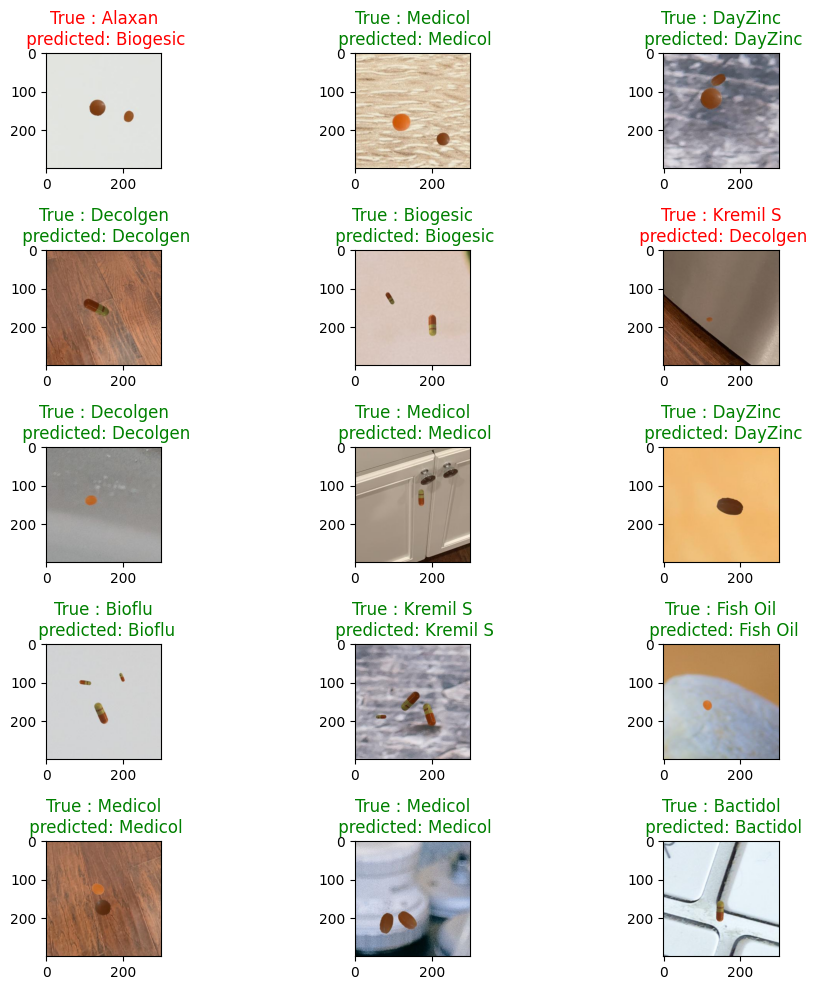

In [16]:
rand_index=np.random.randint(0,len(test_df)-1,15)
fig,axes=plt.subplots(nrows=5,ncols=3,figsize=(10,10))

for i ,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepath[rand_index[i]]))
    if test_df.label.iloc[rand_index[i]]==pred[rand_index[i]]:
        color="green"
    else:
        color="red"
    ax.set_title(f"True : {test_df.label.iloc[rand_index[i]]}\n predicted: {pred[rand_index[i]]}",color=color)
    
plt.tight_layout()

In [17]:
y_test=list(test_df.label)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

      Alaxan       0.84      0.92      0.88       208
    Bactidol       0.89      0.86      0.87       202
      Bioflu       0.87      0.90      0.88       192
    Biogesic       0.81      0.85      0.83       201
     DayZinc       0.94      0.93      0.94       209
    Decolgen       0.91      0.93      0.92       186
    Fish Oil       0.95      0.91      0.93       211
    Kremil S       0.93      0.81      0.87       204
     Medicol       0.96      0.97      0.96       212
      Neozep       0.83      0.84      0.84       175

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000

